# Predicting Video Game Sales

## Notes for cleaning dataset
- 269 dates missing, often for Japanese Releases or Atari 2600 games
- 245 dates added, some games seem to have been cancelled for a platform although there are numbers for sales volume, so it's best to sort them out (by Year_Of_Release == None)
- Many games seem to have been released in Japan only => Should be ignored (JP_Sales == Global_Sales otherwise)
- Some games explicitly stated (jp sales/japan sales/etc.) => merged logically with global title, sometimes strong effect; influence of Japan Sales would be missing for some rows otherwise
- Slightly contradictory information for a few rows merged anyway using max(entry1, entry2)
- "tbd" => None
- Fun Fact: River Raid a top seller!

In [1]:
# TODO: use functions
# TODO: function to find multiple outliers
# TODO: skewedness, boxcox (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html)
# TODO: visualizations
# TODO: check regressor characteristics

# TODO: MAYBE ...
# TODO: test imputation of missing values (http://scikit-learn.org/stable/modules/preprocessing.html#imputation-of-missing-values)
# TODO: test generating polynomial features (http://scikit-learn.org/stable/modules/preprocessing.html#generating-polynomial-features)
# TODO: get more features: "brand"? merge with IGN data?

# Import libraries necessary for this project
import numpy as np
import pandas as pd
import scipy as sp

import visuals as vs # External file, check re-engineering necessity
import matplotlib.pyplot as plt

# Allows the use of display() for DataFrames
from IPython.display import display

# sklearn stuff
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.linear_model import ElasticNet, LassoLars, Ridge
from sklearn import svm

RANDOM_STATE      = 31415
TEST_SIZE         = 0.25
OUTLIER_THRESHOLD = 1.5

# make pretty
plt.style.use('ggplot')

# Pretty display for notebooks
%matplotlib inline

# Data Schema

## Dataset 1 (Video_Games_Sales_as_at_22_Dec_2016.csv)
This is my main dataset. It will be used to predict video game sales.

| title           | description                                                   | data type |
|-----------------|---------------------------------------------------------------|-----------|
| Name            | Name of the game                                              | String    |
| Platform        | Platform                                                      | String    |
| Year_of_Release | Year of release                                               | Numeric   |
| Genre           | Genre                                                         | String    |
| Publisher       | Publisher                                                     | String    |
| NA_Sales        | Game sales in North America (in millions of units)            | Numeric   |
| EU_Sales        | Game sales in the European Union (in millions of units)       | Numeric   |
| JP_Sales        | Game sales in Japan (in millions of units)                    | Numeric   |
| Other_Sales     | Game sales in the rest of the world (in millions of units)    | Numeric   |
| Global_Sales    | Total sales in the world (in millions of units)               | Numeric   |
| Critic_Score    | Aggregate score compiled by Metacritic staff                  | Numeric   |
| Critic_Count    | The number of critics used in coming up with the Critic_score | Numeric   |
| User_Score      | Score by Metacritic's subscribers                             | Numeric   |
| User_Count      | Number of users who gave the user_score                       | Numeric   |
| Developer       | Party responsible for creating the game                       | String    |
| Rating          | The [ESRB](https://www.esrb.org/) ratings                     | String    |

## Dataset 2 (ign.csv)
This is my secondary dataset. It might be used to support the primary dataset, but this would probably require major effort for merging both.

| title           | description                                                   | data type |
|-----------------|---------------------------------------------------------------|-----------|
| ID              | ID                                                            | Numeric   |
| score_phrase    | Game rating as a phrase                                       | String    |
| title           | Name of the game                                              | String    |
| url             | URL to source of data                                         | String    |
| platform        | Platform                                                      | String    |
| score           | Game rating as a float                                        | Numeric   |
| genre           | Genre                                                         | String    |
| editors_choice  | Special recommendation of the editor                          | String    |
| release_year    | Year of release                                               | Numeric   |
| release_month   | Month of release                                              | Numeric   |
| release_day     | Day of release                                                | Numeric   |


We can remove several colums in dataset2 that we don't need:
* **ID** which is just an ID that's not used in dataset 1
* **score_phrase**, because it redundant to _score_ and less precise
* **url**, because that's just the origin of the data
* **release_month**, too much detail
* **release_day**, too much detail
The next step will be to load the datasets.

In [2]:
def loadDatasets(cleaned = True):
    """Load all necessary datasets"""
    # Load dataset #1
    if (cleaned):
        try:
            dataset1 = pd.read_csv("data/Video_Games_Sales_as_at_22_Dec_2016_cleaned.csv")
            display("Dataset #1 has {} samples with {} possible features.".format(*dataset1.shape))
        except:
            display("Dataset #1 could not be loaded. Is the dataset missing?")
    else:
        try:
            dataset1 = pd.read_csv("data/Video_Games_Sales_as_at_22_Dec_2016.csv")
            display("Dataset #1 has {} samples with {} possible features.".format(*dataset1.shape))

            # tbd to NaN (needed for uncleaned dataset)
            clean_dataset1 = clean_dataset1.replace('tbd', float('NaN'))

            # correct data types (needed for uncleaned dataset)
            clean_dataset1['User_Score'] = clean_dataset1['User_Score'].apply(pd.to_numeric)            
        except:
            display("Dataset #1 could not be loaded. Is the dataset missing?")
        
    # Load dataset #2
    try:
        dataset2 = pd.read_csv("data/ign.csv")
        display("Dataset #2 has {} samples with {} possible features.".format(*dataset2.shape))
    except:
        display("Dataset #2 could not be loaded. Is the dataset missing?")

    return dataset1, dataset2

In [3]:
def showDatasetInfos(dataset):
    if (~dataset.empty):
        # Display a description of the datasets
        display(dataset.describe())
        display(dataset.head())
        display(dataset.tail())

In [4]:
def sanitizeDatasets(dataset1):
    if (~dataset1.empty):
        clean_dataset1 = dataset1.copy()

        # beautify strings and kick (needed for uncleaned dataset)
        for i in range(0, len(clean_dataset1.axes[1])):
            if (clean_dataset1.ix[:,i].dtype == object):
                clean_dataset1.ix[:,i] = clean_dataset1.ix[:,i].str.strip()

        # Remove rows with empty values, we want full information
        for column in clean_dataset1.axes[1]:
            clean_dataset1 = clean_dataset1[clean_dataset1[column].notnull()]

        # dataset1 is now clean, make a copy for possibe use later        
        return clean_dataset1.copy()
    else:
        return None

In [5]:
def showColumnInfos(dataset):
# display some infos
    if (~dataset.empty):
        print ('DATASET ROWS: {}'.format(*dataset.shape))
        for item in dataset.keys():
            print ('Unique values for column \'{}\': {}'.format(item, dataset1[item].unique().size))

In [6]:
def createFeaturePlatformManufacturer(dataset):
    # TODO: proper sanitization    
    if (~dataset.empty):
        # Platform manufacturer based on the platform
        man_microsoft = ['PC', 'X360', 'XB', 'XOne'] # Yes, PC could be argued about
        man_nintendo  = ['3DS', 'DS', 'GBA', 'GC', 'N64', 'Wii', 'WiiU']
        man_sega      = ['DC', 'GEN', 'GG','SAT', 'SCD']
        man_sony      = ['PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV']
        man_other     = ['2600', '3DO', 'PC', 'PCFX', 'TG16', 'WS']

        dataset['Platform_Manufacturer'] = dataset['Platform'].map(lambda x:
            'Microsoft' if x in man_microsoft else
            'Nintendo' if x in man_nintendo else
            'Sega' if x in man_sega else
            'Sony' if x in man_sony else
            'Other' if x in man_other else
            float('NaN'))
        return dataset
    else:
        print ('There is something wrong in createFeaturePlatformManufacturer')
        return None

In [7]:
def createFeaturePortables(dataset):
    # TODO: proper sanitization
    if (~dataset.empty):
        # Portable based on the platform
        portables = ['3DS', 'DS', 'GBA', 'GG', 'PSP', 'PSV', 'WS']
        dataset['Portable'] = dataset['Platform'].map(lambda x: True if x in portables else False)
        return dataset
    else:
        print ('There is something wrong in createFeaturePortables')
        return None

In [8]:
def convertNominalFeatures(dataset, columns):
    # TODO: proper sanitization    
    if ((~dataset.empty) & (len(columns) != 0)):
        # create Boolean columns for each nominal variable
        for column in columns:
            if column in dataset.keys():
                for value in dataset[column].unique():
                    dataset[column + '_' + value] = dataset[column].map(lambda x: True if x == value else False)
        return dataset
    else:
        print ('There is something wrong in convertNominalFeatures')
        return None

In [9]:
def separateTargetValues(dataset):
    # separate features and target values (sales volume)
    sales = pd.DataFrame()
    sales['Global'] = dataset['Global_Sales'].copy()
    sales['NA'] = dataset['NA_Sales'].copy()
    sales['EU'] = dataset['EU_Sales'].copy()
    sales['JP'] = dataset['JP_Sales'].copy()
    sales['Other'] = dataset['Other_Sales'].copy()

    # remove target columns
    features = dataset.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], axis=1)
    
    return features, sales

In [10]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

In [11]:
def fit_model(X, y, regressor, params):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 20, test_size=TEST_SIZE, random_state = RANDOM_STATE)

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    
    # Return the optimal model after fitting the data

    return grid.best_estimator_

In [12]:
# Print the results of prediction for both training and testing
def get_r2(X_train, y_train, X_test, y_test):
    r2_train = performance_metric(y_train, reg.predict(X_train))
    r2_test  = performance_metric(y_test, reg.predict(X_test))

    print "For training set, model has a coefficient of determination, R^2, of {:.4f}.".format(r2_train)
    print "For test set, model has a coefficient of determination, R^2, of {:.4f}.".format(r2_test)
    
    return min(r2_train, r2_test)

In [13]:
def showCorrelations(dataset, threshold = None):
    #TODO: sanitization
    if ((type(threshold) != float) & (type(threshold) != int)):
        display(dataset.corr())
    else:
        display(dataset.corr()[abs(dataset.corr()) > threshold])

In [14]:
def dropNominalFeatures(dataset):
    for column in dataset.keys():
        if (dataset[column].dtype == object):
            dataset = dataset.drop(column, axis = 1)
    return dataset

In [15]:
def removeOutliersManually(dataset):
    # There are only few rows before 2000, because MetaCritic was founded in July 16, 1999
    # Also, looking at the sum of global sales grouped by year seamingly reveals a large
    # gap from 2000 to 2001 -- but there probably wasn't such a boost in video game sales, but
    # MetaCritit had to get going. We also have a gap from 2015 to 2016 in the other direction
    # Might be true, might also result from the fact that Christmas is late in the year and
    # games are often sold then which are not yet in the dataset
    # I consider the those rows before 2001 to be outliers to be removed, also those after 2015
    dataset = dataset[(dataset.Year_of_Release > 2000) & (dataset.Year_of_Release < 2016)]

    # Several titles seem to have sold tremendously, but they came along with Hardware bundles,
    # e.g. "Super Mario Kart Wii" with the Wii or "Kinect Adventures!" with the XBox 360
    # Sad to kick these out, as especially the Mario Games are nice!
    dataset = dataset[dataset.Name != 'Wii Sports']
    dataset = dataset[dataset.Name != 'Mario Kart Wii']
    dataset = dataset[dataset.Name != 'Wii Sports Resort']
    dataset = dataset[dataset.Name != 'New Super Mario Bros.']
    dataset = dataset[dataset.Name != 'Wii Play']
    dataset = dataset[dataset.Name != 'New Super Mario Bros. Wii']
    dataset = dataset[dataset.Name != 'Mario Kart DS']
    dataset = dataset[dataset.Name != 'Wii Fit']
    dataset = dataset[dataset.Name != 'Kinect Adventures!']
    dataset = dataset[dataset.Name != 'Wii Fit Plus']
    dataset = dataset[dataset.Name != 'Grand Theft Auto V']
    
    return dataset

In [16]:
def scaleFeatures(dataset):
    min_max_scaler = MinMaxScaler()
    data = min_max_scaler.fit_transform(dataset)
    return pd.DataFrame(data = data, index = dataset.index, columns = dataset.keys())

In [17]:
def normalizeFeatures(dataset):
    return pd.DataFrame(data = scale(dataset), index = dataset.index, columns = dataset.keys())

In [18]:
def boxcoxFeatures(dataset, shift = 1):
    boxcox_lmbda = {}
    for column in dataset:
        if (dataset[column].dtype != object):
            dataset[column], boxcox_lmbda[column] = sp.stats.boxcox(dataset[column] + shift)

    return dataset, boxcox_lmbda

In [19]:
def unboxcoxFeatures(dataset, lmbda, shift = 1):
    for column in dataset:
        if (dataset[column].dtype != object):
            if (lmbda[column] == 0):
              dataset[column] = np.exp(dataset[column])
            else:
              dataset[column] = np.exp(np.log(lmbda[column] * dataset[column] + 1) / lmbda[column]) - shift

    return dataset

In [20]:
def showKBest(features, target, k = 5):
    features_new = SelectKBest(mutual_info_regression, k=5).fit_transform(features, target)
    display(features.head())
    display(pd.DataFrame(features_new).head())

## Begin of analysis

In [21]:
dataset1, dataset2 = loadDatasets()

'Dataset #1 has 16603 samples with 16 possible features.'

'Dataset #2 has 18625 samples with 11 possible features.'

In [22]:
showDatasetInfos(dataset1)

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,16579.000000,16603.000000,16603.000000,16603.000000,16603.000000,16603.000000,8137.000000,8137.000000,7590.000000,7590.000000
mean,2006.473129,0.264786,0.145962,0.078023,0.047637,0.536665,68.967679,26.360821,7.125046,162.229908
std,5.932192,0.815941,0.504897,0.309813,0.187323,1.552928,13.938165,18.980495,1.500006,561.282326
min,1977.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,6.400000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,7.500000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,8.200000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,9.700000,10665.000000


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
16598,XI Coliseum,PSP,2006.0,Puzzle,Sony Computer Entertainment,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16599,Yattaman Wii: BikkuriDokkiri Machine de Mou Ra...,Wii,2008.0,Racing,Takara Tomy,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16600,Zero no Tsukaima: Maigo no Period to Ikusen no...,PS2,2008.0,Adventure,Marvelous Interactive,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16601,Zettai Kaikyuu Gakuen: Eden with Roses and Pha...,PSV,2016.0,Adventure,Prototype,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16602,ZombiU,XOne,2016.0,Action,Ubisoft,0.0,0.01,0.00,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Sanitization
clean_dataset1 = sanitizeDatasets(dataset1)

# Infos
showColumnInfos(clean_dataset1)

DATASET ROWS: 6942
Unique values for column 'Name': 11435
Unique values for column 'Platform': 31
Unique values for column 'Year_of_Release': 43
Unique values for column 'Genre': 13
Unique values for column 'Publisher': 580
Unique values for column 'NA_Sales': 402
Unique values for column 'EU_Sales': 307
Unique values for column 'JP_Sales': 244
Unique values for column 'Other_Sales': 155
Unique values for column 'Global_Sales': 629
Unique values for column 'Critic_Score': 83
Unique values for column 'Critic_Count': 107
Unique values for column 'User_Score': 96
Unique values for column 'User_Count': 889
Unique values for column 'Developer': 1697
Unique values for column 'Rating': 9


In [24]:
# Feature Generation and further harmonizing data

# make a short dataset that will contain all rows considered for further analysis

short_dataset1 = clean_dataset1.copy()

#rescale column for human readability
short_dataset1['User_Score'] = short_dataset1['User_Score'] * 10

# make feature for "platform manufacturer"
short_dataset1 = createFeaturePlatformManufacturer(short_dataset1)

# make feature for "portable"
short_dataset1 = createFeaturePortables(short_dataset1)

showDatasetInfos(short_dataset1)

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000
mean,2007.424517,0.393222,0.234968,0.063940,0.082244,0.774568,70.270815,28.877845,71.842553,173.819793
std,4.204915,0.961456,0.682568,0.285433,0.267921,1.949378,13.884912,19.197734,14.409487,584.709510
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,5.000000,4.000000
25%,2004.000000,0.060000,0.020000,0.000000,0.010000,0.110000,62.000000,14.000000,65.000000,11.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000,72.000000,24.000000,75.000000,27.000000
75%,2010.000000,0.390000,0.210000,0.020000,0.070000,0.750000,80.000000,39.000000,82.000000,88.000000
max,2016.000000,41.360000,28.960000,6.500000,10.570000,82.530000,98.000000,113.000000,96.000000,10665.000000


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Platform_Manufacturer,Portable
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,80.0,322.0,Nintendo,E,Nintendo,False
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,83.0,709.0,Nintendo,E,Nintendo,False
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,80.0,192.0,Nintendo,E,Nintendo,False
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,85.0,431.0,Nintendo,E,Nintendo,True
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,66.0,129.0,Nintendo,E,Nintendo,False


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Platform_Manufacturer,Portable
16114,Greg Hastings' Tournament Paintball Max'd,PS2,2006.0,Shooter,Activision,0.01,0.00,0.0,0.0,0.01,70.0,8.0,92.0,32.0,Activision Value,E10+,Sony,False
16115,Deus Ex,PC,2000.0,Role-Playing,Eidos Interactive,0.00,0.01,0.0,0.0,0.01,90.0,28.0,93.0,1069.0,Ion Storm,M,Microsoft,False
16116,Monster Rancher Advance 2,GBA,2002.0,Simulation,Tecmo Koei,0.01,0.00,0.0,0.0,0.01,79.0,5.0,94.0,9.0,"Tecmo, Graphic Research",E,Nintendo,True
16117,Wade Hixton's Counter Punch,GBA,2004.0,Sports,"Destination Software, Inc",0.01,0.00,0.0,0.0,0.01,78.0,13.0,95.0,4.0,Inferno Games,T,Nintendo,True
16118,Karnaaj Rally,GBA,2003.0,Racing,Jaleco,0.01,0.00,0.0,0.0,0.01,81.0,9.0,95.0,4.0,"Infinite Dreams, Paragon 5",E,Nintendo,True


In [25]:
# Outliers (manually)
groups = short_dataset1['Global_Sales'].groupby(short_dataset1['Year_of_Release'])
display(groups.sum()) # TODO: visually
display(short_dataset1.sort_values(['Global_Sales'], ascending = False).head(15))

short_dataset1 = removeOutliersManually(short_dataset1)

# display some infos
print ('REMAINING ROWS IN DATASET #1: {}'.format(*short_dataset1.shape))
print ('Dataset #1 has games from {} unique years'.format(short_dataset1['Year_of_Release'].unique().size))

Year_of_Release
1985.0      0.03
1988.0      0.03
1992.0      0.03
1994.0      1.27
1996.0     20.10
1997.0     35.01
1998.0     43.18
1999.0     52.21
2000.0     81.24
2001.0    256.32
2002.0    296.78
2003.0    265.62
2004.0    323.79
2005.0    336.95
2006.0    422.86
2007.0    464.15
2008.0    504.09
2009.0    460.48
2010.0    417.33
2011.0    391.79
2012.0    292.82
2013.0    267.78
2014.0    192.43
2015.0    159.16
2016.0     91.60
Name: Global_Sales, dtype: float64

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Platform_Manufacturer,Portable
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,80.0,322.0,Nintendo,E,Nintendo,False
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,83.0,709.0,Nintendo,E,Nintendo,False
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,80.0,192.0,Nintendo,E,Nintendo,False
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,85.0,431.0,Nintendo,E,Nintendo,True
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,66.0,129.0,Nintendo,E,Nintendo,False
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.44,6.94,4.70,2.24,28.32,87.0,80.0,84.0,594.0,Nintendo,E,Nintendo,False
11,Mario Kart DS,DS,2005.0,Racing,Nintendo,9.71,7.47,4.13,1.90,23.21,91.0,64.0,86.0,464.0,Nintendo,E,Nintendo,True
13,Wii Fit,Wii,2007.0,Sports,Nintendo,8.92,8.03,3.60,2.15,22.70,80.0,63.0,77.0,146.0,Nintendo,E,Nintendo,False
14,Kinect Adventures!,X360,2010.0,Misc,Microsoft Game Studios,15.00,4.89,0.24,1.69,21.81,61.0,45.0,63.0,106.0,Good Science Studio,E,Microsoft,False
15,Wii Fit Plus,Wii,2009.0,Sports,Nintendo,9.01,8.49,2.53,1.77,21.79,80.0,33.0,74.0,52.0,Nintendo,E,Nintendo,False


REMAINING ROWS IN DATASET #1: 6532
Dataset #1 has games from 15 unique years


In [26]:
# Show correlations between all variables
showCorrelations(short_dataset1, 0.7)

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Portable
Year_of_Release,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NA_Sales,NaN,1.000000,0.702105,NaN,NaN,0.919290,NaN,NaN,NaN,NaN,NaN
EU_Sales,NaN,0.702105,1.000000,NaN,NaN,0.879879,NaN,NaN,NaN,NaN,NaN
JP_Sales,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Other_Sales,NaN,NaN,NaN,NaN,1.000000,0.733975,NaN,NaN,NaN,NaN,NaN
Global_Sales,NaN,0.919290,0.879879,NaN,0.733975,1.000000,NaN,NaN,NaN,NaN,NaN
Critic_Score,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Critic_Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
User_Score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
User_Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In order to understand the dataset better, we should have a look at possible values.

In [27]:
# => too many unique values per feature for the dataset size, so features should be removed
short_dataset1 = short_dataset1.drop(['Name', 'Publisher', 'Developer'], axis=1)

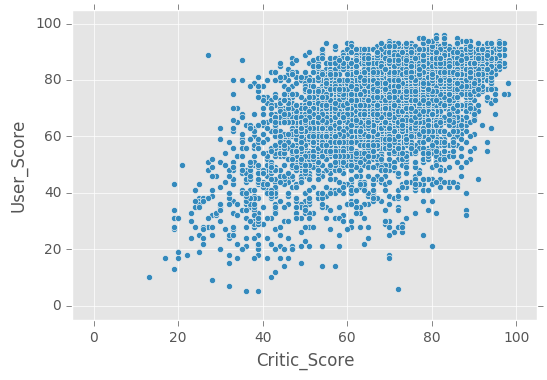

In [28]:
# Critic_Score and User_Score
short_dataset1.plot.scatter(x='Critic_Score', y='User_Score', xlim=(-5, 105), ylim=(-5,105))

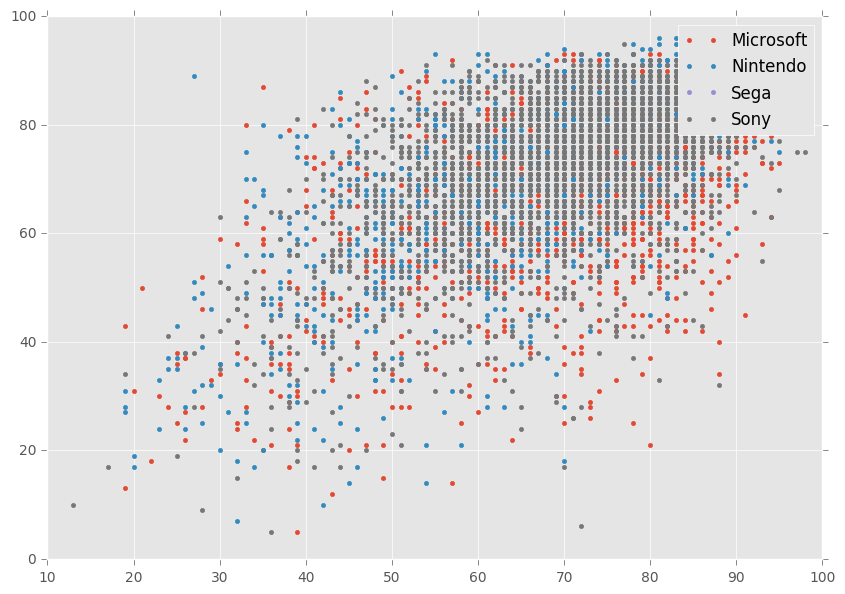

In [29]:
# Just for testing
if ('Platform_Manufacturer' in short_dataset1.keys()):
    groups = short_dataset1.groupby('Platform_Manufacturer')

    # Plot
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    for name, group in groups:
        ax.plot(group.Critic_Score, group.User_Score, marker='.', linestyle='', label=name)
    ax.legend()
    plt.show()
    #fig.savefig('yourfilename.png')

In [30]:
# convert nominal features to boolean features
short_dataset1 = convertNominalFeatures(short_dataset1, ['Platform', 'Genre', 'Rating', 'Platform_Manufacturer'])
short_dataset1 = dropNominalFeatures(short_dataset1)

# normalize features
#short_dataset1 = normalizeFeatures(short_dataset1)

# test_set
test_set = short_dataset1.copy()

# scale features to range [0, 1]
# short_dataset1 = scaleFeatures(short_dataset1)

# run Box-Cox transformation
short_dataset1, boxcox_lmbda = boxcoxFeatures(dataset = short_dataset1.copy())

In [31]:
# TESTING: OUTLIER DETECTION
# We can't simply throw away just by a threshold, we gotta look at the data

# TODO: visual checks first!

# For each feature find the data points with extreme high or low values

# TODO: CHECK FOR MULTIPLE OUTLIERS

for feature in ['Year_of_Release', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']:
    if short_dataset1[feature].dtype == float:

        # Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = short_dataset1[feature].quantile(0.25)

        # Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = short_dataset1[feature].quantile(0.75)

        # Use the interquartile range to calculate an outlier step (OUTLIER_THRESHOLD times the interquartile range)
        step = (Q3 - Q1) * OUTLIER_THRESHOLD

        # Display the outlier count
        print "Data points considered outliers for the feature '{}': {}".format(feature, short_dataset1[~((short_dataset1[feature] >= Q1 - step) & (short_dataset1[feature] <= Q3 + step))].shape[0])

        # TODO: optionally remove outliers
        #short_dataset1 = short_dataset1[~((short_dataset1[feature] >= Q1 - step) & (short_dataset1[feature] <= Q3 + step))]
 
display(short_dataset1.describe())
display(short_dataset1.head())

Data points considered outliers for the feature 'Year_of_Release': 0
Data points considered outliers for the feature 'Critic_Score': 0
Data points considered outliers for the feature 'Critic_Count': 0
Data points considered outliers for the feature 'User_Score': 0
Data points considered outliers for the feature 'User_Count': 0


,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,...,Rating_M,Rating_E,Rating_T,Rating_E10+,Rating_AO,Rating_RP,Platform_Manufacturer_Sony,Platform_Manufacturer_Nintendo,Platform_Manufacturer_Microsoft,Platform_Manufacturer_Sega
count,6.532000e+03,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,...,6532.000000,6532.000000,6532.000000,6532.000000,6.532000e+03,6.532000e+03,6532.000000,6532.000000,6532.000000,6.532000e+03
mean,3.228520e-01,0.134781,0.071556,0.009853,0.028614,0.228950,6118.985333,4.788072,68248.023361,2.176689,...,0.031177,0.075479,0.105874,0.013579,1.624550e-08,1.624550e-08,0.154588,0.056959,0.093784,2.599280e-07
std,1.105859e-13,0.096578,0.064789,0.017608,0.026042,0.148607,2347.891689,1.391010,29730.799373,0.499139,...,0.060832,0.113957,0.145231,0.033712,1.312974e-06,1.312974e-06,0.190974,0.093253,0.133114,1.050138e-05
min,3.228520e-01,0.000000,0.000000,0.000000,0.000000,0.009859,157.821853,1.628137,54.897355,1.298044,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
25%,3.228520e-01,0.053487,0.018869,0.000000,0.009386,0.100398,4471.176968,3.855596,47434.345928,1.795292,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
50%,3.228520e-01,0.114292,0.050664,0.000000,0.017652,0.203045,6202.486884,4.816075,70582.816502,2.159657,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
75%,3.228520e-01,0.209724,0.120389,0.009064,0.046543,0.346968,7814.417752,5.818212,90468.167596,2.553192,...,0.000000,0.247503,0.305060,0.000000,0.000000e+00,0.000000e+00,0.390476,0.209608,0.282694,0.000000e+00
max,3.228520e-01,0.335015,0.203338,0.052509,0.084421,0.538454,12204.023842,8.325337,140345.549762,3.328653,...,0.149851,0.247503,0.305060,0.097259,1.061156e-04,1.061156e-04,0.390476,0.209608,0.282694,4.244625e-04


,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,...,Rating_M,Rating_E,Rating_T,Rating_E10+,Rating_AO,Rating_RP,Platform_Manufacturer_Sony,Platform_Manufacturer_Nintendo,Platform_Manufacturer_Microsoft,Platform_Manufacturer_Sega
17,0.322852,0.334992,0.164473,0.052433,0.084421,0.538454,11397.639055,7.522553,117240.662566,3.137410,...,0.149851,0.000000,0.0,0.0,0.0,0.0,0.390476,0.000000,0.0,0.0
19,0.322852,0.333472,0.203338,0.052509,0.084421,0.538349,7185.953215,6.696593,81555.814312,2.393248,...,0.000000,0.247503,0.0,0.0,0.0,0.0,0.000000,0.209608,0.0,0.0
24,0.322852,0.334882,0.203320,0.052474,0.084421,0.537446,11397.639055,6.862735,106675.387276,3.025371,...,0.149851,0.000000,0.0,0.0,0.0,0.0,0.390476,0.000000,0.0,0.0
26,0.322852,0.331341,0.203318,0.052509,0.084413,0.537166,7185.953215,5.643775,60610.681438,2.034270,...,0.000000,0.247503,0.0,0.0,0.0,0.0,0.000000,0.209608,0.0,0.0
28,0.322852,0.334581,0.203312,0.052509,0.084412,0.537054,11397.639055,6.521491,96744.758786,2.873261,...,0.000000,0.247503,0.0,0.0,0.0,0.0,0.390476,0.000000,0.0,0.0


In [ ]:
# split data into training set and test set
# separate features from target values
features, sales = separateTargetValues(short_dataset1)
test_features, test_sales = separateTargetValues(test_set)

# get five best predictors: Year, Scores, PC and Microsoft
showKBest(features, sales['Global'])
    
# shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, sales['Global'], test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Success
print "Training and testing split was successful."

,Year_of_Release,Critic_Score,Critic_Count,User_Score,User_Count,Portable,Platform_PS2,Platform_DS,Platform_X360,Platform_PS3,...,Rating_M,Rating_E,Rating_T,Rating_E10+,Rating_AO,Rating_RP,Platform_Manufacturer_Sony,Platform_Manufacturer_Nintendo,Platform_Manufacturer_Microsoft,Platform_Manufacturer_Sega
17,0.322852,11397.639055,7.522553,117240.662566,3.137410,0.000000,0.120728,0.00000,0.0,0.0,...,0.149851,0.000000,0.0,0.0,0.0,0.0,0.390476,0.000000,0.0,0.0
19,0.322852,7185.953215,6.696593,81555.814312,2.393248,0.149467,0.000000,0.04945,0.0,0.0,...,0.000000,0.247503,0.0,0.0,0.0,0.0,0.000000,0.209608,0.0,0.0
24,0.322852,11397.639055,6.862735,106675.387276,3.025371,0.000000,0.120728,0.00000,0.0,0.0,...,0.149851,0.000000,0.0,0.0,0.0,0.0,0.390476,0.000000,0.0,0.0
26,0.322852,7185.953215,5.643775,60610.681438,2.034270,0.149467,0.000000,0.04945,0.0,0.0,...,0.000000,0.247503,0.0,0.0,0.0,0.0,0.000000,0.209608,0.0,0.0
28,0.322852,11397.639055,6.521491,96744.758786,2.873261,0.000000,0.120728,0.00000,0.0,0.0,...,0.000000,0.247503,0.0,0.0,0.0,0.0,0.390476,0.000000,0.0,0.0


,0,1,2,3,4
0,11397.639055,7.522553,3.137410,0.0,0.149851
1,7185.953215,6.696593,2.393248,0.0,0.000000
2,11397.639055,6.862735,3.025371,0.0,0.149851
3,7185.953215,5.643775,2.034270,0.0,0.000000
4,11397.639055,6.521491,2.873261,0.0,0.000000


Training and testing split was successful.


In [ ]:
# http://scikit-learn.org/stable/tutorial/machine_learning_map/

regressors = [0, 1, 2, 3, 4, 5]
reg_params = [0, 1, 2, 3, 4, 5]
reg_score = [0, 1, 2, 3, 4, 5]
reg_gap = [0, 1, 2, 3, 4, 5]

# create a RidgeRegression regressor object (best: 0.3096)
regressor = Ridge(random_state = RANDOM_STATE)
params = {'alpha': [0.1, 0.12, 0.13, 0.14, 0.17, 0.2],    # positve float
          'fit_intercept': [True, False], # boolean
          'max_iter': [1500],             # integer
          'normalize': [True, False],     # boolean
          'solver': ['auto'] # {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag'}
         }
regressors[0] = regressor
reg_params[0] = params

# create a support vector regressor object
regressor = svm.SVR()
params = {'C': [0.1, 0.3, 0.7, 1.0, 1.3],
          'kernel': ['linear', 'rbf'],
          'epsilon': [0.1, 0.3, 0.7, 1.0, 1.3],
          'gamma': ['auto']
         }       
regressors[1] = regressor
reg_params[1] = params

# create a decision tree regressor object
regressor = DecisionTreeRegressor(random_state = RANDOM_STATE)
params = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}
regressors[2] = regressor
reg_params[2] = params

# create a LarsLasso regressor object
regressor = LassoLars()
params = {'alpha': [0.03, 0.07, 0.1, 0.13],
          'fit_intercept': [True, False],
          'positive': [True, False],
          'normalize': [True, False],
          'max_iter': [1200, 1500]
         }
regressors[3] = regressor
reg_params[3] = params

# create a ElasticNet regressor object
regressor = ElasticNet()
params = {'alpha': [0.07, 0.1],
          'l1_ratio': [0, 0.1, 0.2, 0.3],
          'fit_intercept': [True, False],
          'normalize': [True, False],
          'max_iter' : [1200]
         }
regressors[4] = regressor
reg_params[4] = params

# create a Neural Network regressor object
regressor = MLPRegressor(random_state = RANDOM_STATE)
params = {'hidden_layer_sizes': [(150,), (200,), (250,)],
          'alpha': [0.00093, 0.00097, 0.0001, 0.00013],
          'solver': ['lbfgs', 'sgd', 'adam']
         }
regressors[5] = regressor
reg_params[5] = params

best_score = 0
best_gap = 0
for index in range(2):
# for index in range(len(regressors)):
    # Fit the training data to the model using grid search
    reg = fit_model(X_train, y_train, regressors[index], reg_params[index])
    vs.DisplayLearningCurve(X_train, y_train, reg, params)
    reg_score[index] = performance_metric(sales['Global'], reg.predict(features))
    reg_gap[index]  = abs(performance_metric(y_train, reg.predict(X_train)) - performance_metric(y_test, reg.predict(X_test)))
    display('----------')
    display(reg)
    display('The gap between training set and test set is {:.4f}.'.format(reg_gap[index]))
    display('The overall model has a coefficient of determination, R^2, of {:.4f}.'.format(reg_score[index]))
    best_gap = (min(best_gap, reg_gap[index]))
    best_score = (max(best_score, reg_score[index]))
    
    
display('==========')
display(best_score)

"""
Ridge(alpha=0.17, copy_X=True, fit_intercept=False, max_iter=1200,
   normalize=True, random_state=31415, solver='sparse_cg', tol=0.001)
'The gap between training set and test set is 0.0081.'
'The overall model has a coefficient of determination, R^2, of 0.3096.'

Ridge(alpha=0.2, copy_X=True, fit_intercept=False, max_iter=1500,
   normalize=True, random_state=31415, solver='sparse_cg', tol=0.001)
'The gap between training set and test set is 0.0081.'
'The overall model has a coefficient of determination, R^2, of 0.3096.'

SVR(C=0.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
'The gap between training set and test set is 0.0004.'
'The overall model has a coefficient of determination, R^2, of 0.3469.'

SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
'The gap between training set and test set is 0.0139.'
'The overall model has a coefficient of determination, R^2, of 0.4204.'

SVR(C=0.6, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
'The gap between training set and test set is 0.0118.'
'The overall model has a coefficient of determination, R^2, of 0.4075.'

SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
'The gap between training set and test set is 0.0323.'
'The overall model has a coefficient of determination, R^2, of 0.4683.'

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=False, l1_ratio=0,
      max_iter=1200, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
'The gap between training set and test set is 0.0064.'
'The overall model has a coefficient of determination, R^2, of 0.3065.'

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
'The gap between training set and test set is 0.2250.'
'The overall model has a coefficient of determination, R^2, of 0.6071.'

MLPRegressor(activation='relu', alpha=0.00097, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=300, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
'The gap between training set and test set is 0.6775.'
'The overall model has a coefficient of determination, R^2, of 0.5122.'

MLPRegressor(activation='relu', alpha=0.00097, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(150,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=31415,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
'The gap between training set and test set is 0.4093.'
'The overall model has a coefficient of determination, R^2, of 0.5739.'

"""

'----------'

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1500,
   normalize=True, random_state=31415, solver='auto', tol=0.001)

'The gap between training set and test set is 0.0046.'

'The overall model has a coefficient of determination, R^2, of 0.5026.'

In [ ]:
display(test_features.iloc[0:5])
display(test_sales['Global'].iloc[0:5])